# CSC420 Assignment 3 Question 3

## Step 0: Preparation

### Step 0.0: Import packages and images

In [13]:
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import math
from scipy.special import softmax

### Step 0.1 Import images

In [14]:
def get_image(path):
    raw_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    croped_image = np.asarray(cv2.resize(raw_image, (900, 1200), interpolation = cv2.INTER_AREA))
    plt.imshow(croped_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.imshow
    return croped_image

In [15]:
def get_gradient(image):
    sobelx = np.array(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3))
    sobely = np.array(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3))
    gradient = np.array([sobelx, sobely])
    gradient = gradient.transpose(1, 2, 0)
    gradient_magnitude = np.sqrt(sobelx * sobelx + sobely * sobely)
    print(gradient.shape, gradient_magnitude.shape)
    return gradient, gradient_magnitude

In [16]:
def clip_and_count(gradient, threshold=70):
    flags = 0 * np.ones(shape=(gradient.shape[0], gradient.shape[1]), dtype=int)
    height = gradient.shape[0]
    width = gradient.shape[1]
    groups = []
    for h in range(height):
        for w in range(width):
            magnitude = np.linalg.norm(gradient[h][w])
            if magnitude >= threshold:
                ratio = np.divide(gradient[h][w][0], gradient[h][w][1],
                                  out=np.zeros_like(gradient[h][w][0]), where=gradient[h][w][1]!=0)
                direction = (np.arctan(ratio) * 180 / math.pi)
                if direction >= 0:
                    group = int((direction + 15) / 25)
                else:
                    group = int((180 - np.abs(direction) + 15) / 25)
                flags[h][w] = group + 1
                if group not in groups:
                    groups.append(group)
                    groups.append(direction)
    flags[flags > 6] = 1
    return flags

In [17]:
def count_by_boxes(flags, tau=48):
    height = flags.shape[0]
    width = flags.shape[1]
    groups = np.zeros(shape=(tau, tau, 6), dtype=int)
    dh = int(height/tau)
    dw = int(width/tau)
    for h in range(tau):
        for w in range(tau):
            start_h = h * dh
            end_h = start_h + dh
            strat_w = w * dw
            end_w = strat_w + dw
            slice = flags[start_h:end_h]
            block = slice.T[strat_w:end_w].flatten()
            for k in range(6):
                groups[h][w][k] = np.count_nonzero(block == (k+1))
    return groups

In [18]:
def add_by_boxes(magnitude, flags, tau=48):
    added = np.zeros(shape=(tau, tau, 6), dtype=float)
    height = flags.shape[0]
    width = flags.shape[1]
    dh = int(height/tau)
    dw = int(width/tau)
    for h in range(tau):
        for w in range(tau):
            start_h = h * dh
            end_h = start_h + dh
            strat_w = w * dw
            end_w = strat_w + dw
            flag_slice = flags[start_h:end_h]
            magnitude_slice = magnitude[start_h:end_h]
            flag_block = flag_slice.transpose(1, 0)[strat_w:end_w].transpose(1, 0).flatten()
            magnitude_block = magnitude_slice.transpose(1, 0)[strat_w:end_w].transpose(1, 0).flatten()
            for k in range(6):
                indices = np.where(flag_block == (k+1))
                vals = np.take(magnitude_block, indices)
                added[h][w][k] = np.sum(vals)
    return added

In [19]:
def graph_by_box(image, group_box, tau=48):
    """
        Calculate the angels in prior for less computaiotn
    """
    x_ratios = np.zeros(shape=(6,), dtype=float)
    y_ratios = np.zeros(shape=(6,), dtype=float)
    for k in range(6):
        x_ratios[k] = np.cos(k * math.pi / 6)
        y_ratios[k] = np.sin(k * math.pi / 6)

    dw = int(image.shape[0] / tau)
    dh = int(image.shape[1] / tau)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 20, forward=True)
    ax.imshow(image, cmap='gray')
    for i in range(tau):
        for j in range(tau):
            x_pos = i * dw + int(dw/2)
            y_pos = j * dh + int(dh/2)
            for k in range(6):
                val = group_box[i][j][k]
                g = group_box[i][j]
                x_ratio = x_ratios[k]
                y_ratio = y_ratios[k]
                magnitude = val / max(np.sum(g), 1)
                x_direct = x_ratio * magnitude
                y_direct = y_ratio * magnitude
                ax.quiver(y_pos, x_pos, x_direct, y_direct, width=0.002, scale=1, scale_units='inches', color='r')
                ax.quiver(y_pos, x_pos, -x_direct, -y_direct, width=0.002,
                          scale=1, scale_units='inches', color='r')
    plt.show()
    return None

In [20]:
def graph_by_box_soft_max(image, grouped, tau=48):
    shape = image.shape
    dw = int(shape[0] / tau)
    dh = int(shape[1] / tau)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 20, forward=True)
    ax.imshow(image, cmap='gray')
    for i in range(tau):
        for j in range(tau):
            x_pos = i * dw + int(dw/2)
            y_pos = j * dh + int(dh/2)
            for k in range(6):
                val = grouped[i][j][k]
                group = grouped[i][j]
                normalized = softmax(group)
                x_ratio = np.cos(k * math.pi / 6)
                y_ratio = np.sin(k * math.pi / 6)
                if val != 0:
                    magnitude = normalized[k]
                else:
                    magnitude = 0
                x_direct = x_ratio * magnitude
                y_direct = y_ratio * magnitude
                ax.quiver(y_pos, x_pos, x_direct, y_direct, width=0.002, scale=1, scale_units='inches', color='r')
                ax.quiver(y_pos, x_pos, -x_direct, -y_direct, width=0.002,
                          scale=1, scale_units='inches', color='r')
    plt.show()
    return None

In [21]:
def l2_normalize(tensor, tau=48):
    normalized_tensor =np.zeros(shape=(tensor.shape[0]-1, tensor.shape[1]-1, 6), dtype=float)
    height = tensor.shape[0]
    width = tensor.shape[1]
    dh = int(height/tau)
    dw = int(width/tau)
    for h in range(tau-1):
        for w in range(tau-1):
            start_h = h * dh
            end_h = start_h + dh * 2
            strat_w = w * dw
            end_w = strat_w + dw * 2
            sliced = tensor[start_h:end_h]
            block = sliced.transpose(1, 0, 2)[strat_w:end_w].transpose(1, 0, 2).transpose(2, 0, 1)
            unnormalized_vector = np.sum(np.sum(block, axis=1), axis=1)
            normalized = unnormalized_vector / np.sqrt(np.sum(unnormalized_vector * unnormalized_vector))
            normalized_tensor[h][w]  = normalized
    return normalized_tensor


In [22]:
def graph_normalized(image, tensor, new_tau=48-1):
    """
        Calculate the angels in prior for less computaiotn
    """
    x_ratios = np.zeros(shape=(6,), dtype=float)
    y_ratios = np.zeros(shape=(6,), dtype=float)
    for k in range(6):
        x_ratios[k] = np.cos(k * math.pi / 6)
        y_ratios[k] = np.sin(k * math.pi / 6)

    dw = int(image.shape[0] / new_tau)
    dh = int(image.shape[1] / new_tau)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 20, forward=True)
    ax.imshow(image, cmap='gray')
    for h in range(new_tau):
        for w in range(new_tau):
            x_pos = h * dw + int(dw/2)
            y_pos = w * dh + int(dh/2)
            for k in range(6):
                magnitude = tensor[h][w][k]
                x_ratio = x_ratios[k]
                y_ratio = y_ratios[k]
                x_direct = x_ratio * magnitude
                y_direct = y_ratio * magnitude
                ax.quiver(y_pos, x_pos, x_direct, y_direct, width=0.002, scale=1, scale_units='inches', color='r')
                ax.quiver(y_pos, x_pos, -x_direct, -y_direct, width=0.002,
                          scale=1, scale_units='inches', color='r')
    plt.show()
    return None

## Demonstration, Image 1

(1200, 900, 2) (1200, 900)


/var/folders/54/6559nwv928s2mg9_mxm8dt0r0000gn/T/ipykernel_86524/2813269325.py:16: RuntimeWarning: invalid value encountered in true_divide
  normalized = unnormalized_vector / np.sqrt(np.sum(unnormalized_vector * unnormalized_vector))


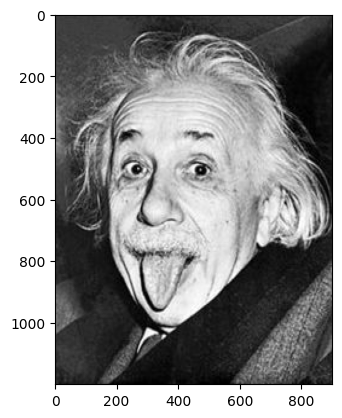

In [23]:
threshold = 50
tau = 30
image = get_image('Q3/1.jpg')
gradient, gradient_magnitude = get_gradient(image)
flags = clip_and_count(gradient=gradient, threshold=threshold)
grouped = count_by_boxes(flags)
added = add_by_boxes(gradient_magnitude, flags)
normalized = l2_normalize(added)

## Image 1, approach 1

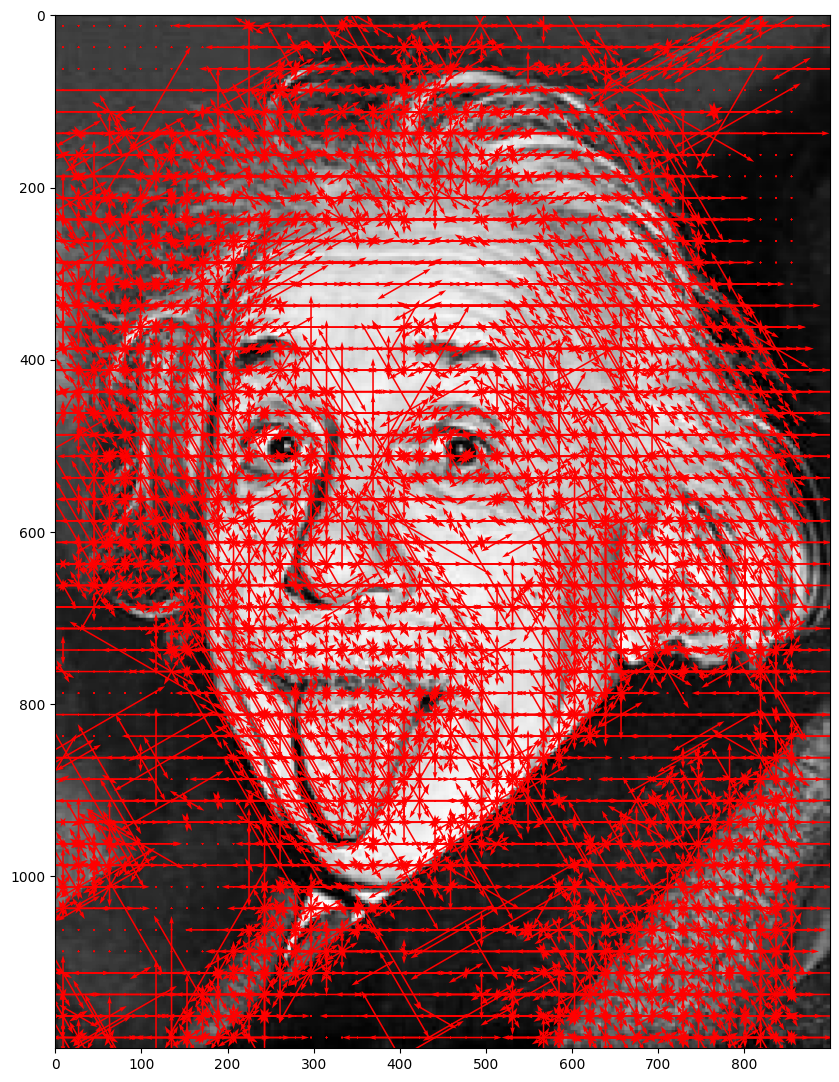

In [24]:
graph_by_box(image, grouped)

## Image 1, approach 2

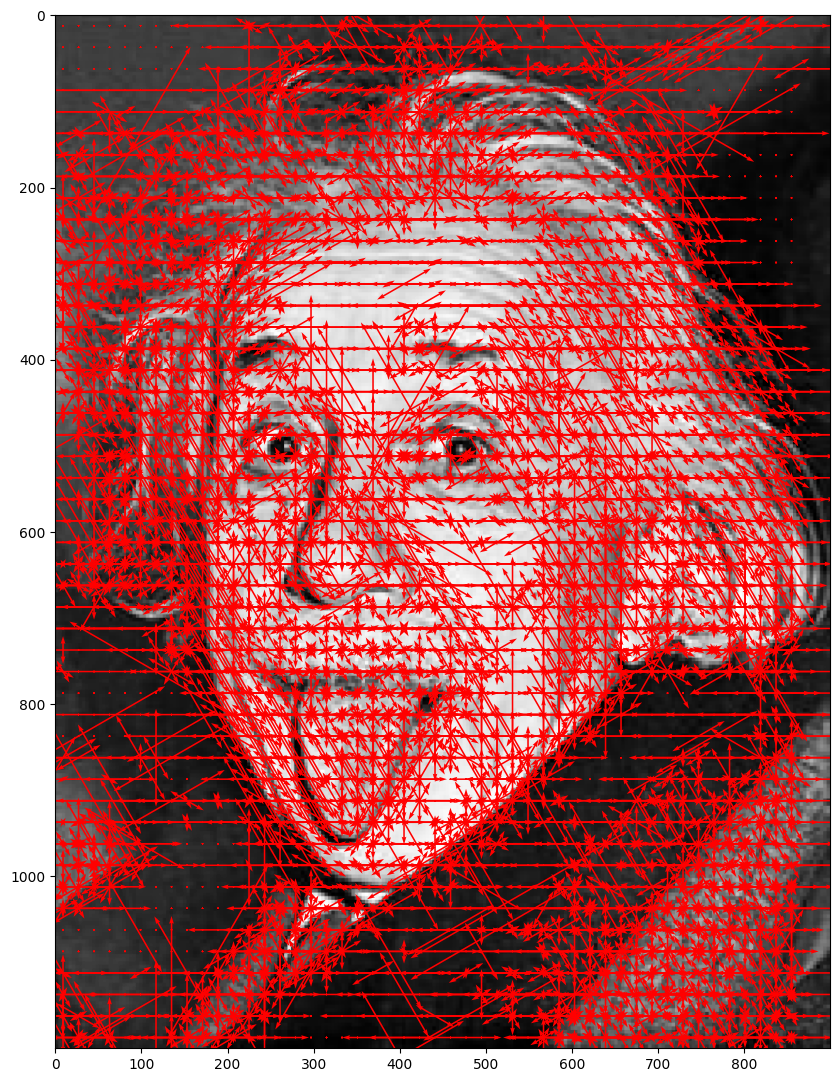

In [25]:
graph_by_box(image, added)

## Image 1, L2 Normalize

In [ ]:
graph_normalized(image, normalized)
np.savetxt("Image1.txt", normalized, delimiter=",")

## Demonstration, image 2

In [ ]:
threshold = 75
image = get_image('Q3/2.jpg')
gradient, gradient_magnitude = get_gradient(image)
flags = clip_and_count(gradient=gradient, threshold=threshold)
grouped = count_by_boxes(flags)
added = add_by_boxes(gradient_magnitude, flags)
normalized = l2_normalize(added)

## Image 2, approach 1

In [ ]:
graph_by_box(image, grouped)

## Image 2, approach 2

In [ ]:
graph_by_box(image, added)

## Image 2, L2 Normalize

In [ ]:
graph_normalized(image, normalized)
np.savetxt("Image2.txt", normalized, delimiter=",")

## Demonstration, image 3

In [ ]:
threshold = 40
tau = 30
image = get_image('Q3/3.jpg')
gradient, gradient_magnitude = get_gradient(image)
flags = clip_and_count(gradient=gradient, threshold=threshold)
grouped = count_by_boxes(flags)
added = add_by_boxes(gradient_magnitude, flags)
normalized = l2_normalize(added)

## Image 3, approach 1

In [ ]:
graph_by_box(image, grouped)

## Image 3, approach 2

In [ ]:
graph_by_box(image, added)

## Image 3, L2 Normalize

In [ ]:
graph_normalized(image, normalized)
np.savetxt("Image3.txt", normalized, delimiter=",")

## Image 1, approach 2

In [ ]:
graph_by_box(image, added)

## Image 1, L2 Normalize

In [ ]:
graph_normalized(image, normalized)

## Demonstration, image 2

In [ ]:
threshold = 75
image = get_image('Q3/2.jpg')
gradient, gradient_magnitude = get_gradient(image)
flags = clip_and_count(gradient=gradient, threshold=threshold)
grouped = count_by_boxes(flags)
added = add_by_boxes(gradient_magnitude, flags)
normalized = l2_normalize(added)

## Image 2, approach 1

In [ ]:
graph_by_box(image, grouped)

## Image 2, approach 2

In [ ]:
graph_by_box(image, added)

## Image 2, L2 Normalize

In [ ]:
graph_normalized(image, normalized)

## Demonstration, image 3

In [ ]:
threshold = 40
tau = 30
image = get_image('Q3/3.jpg')
gradient, gradient_magnitude = get_gradient(image)
flags = clip_and_count(gradient=gradient, threshold=threshold)
grouped = count_by_boxes(flags)
added = add_by_boxes(gradient_magnitude, flags)
normalized = l2_normalize(added)

## Image 3, approach 1

In [ ]:
graph_by_box(image, grouped)

## Image 3, approach 2

In [ ]:
graph_by_box(image, added)

## Image 3, L2 Normalize

In [ ]:
graph_normalized(image, normalized)